<a href="https://colab.research.google.com/github/kmuhan/kmuhandeeplearning/blob/main/iris_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Epoch: 0/1000 Error_train : 1.1006521871172625 Error_test: 1.1013944458055915
Epoch: 100/1000 Error_train : 0.02326479644425348 Error_test: 0.07541554113398714
Epoch: 200/1000 Error_train : 0.005901571517947568 Error_test: 0.09069786048816444
Epoch: 300/1000 Error_train : 0.00255818215134104 Error_test: 0.10093697233131042
Epoch: 400/1000 Error_train : 0.001510427387413724 Error_test: 0.11032802431878397
Epoch: 500/1000 Error_train : 0.0010055471143193366 Error_test: 0.11887282139773321
Epoch: 600/1000 Error_train : 0.0007361536772420987 Error_test: 0.12624462563560643
Epoch: 700/1000 Error_train : 0.0005756823156960845 Error_test: 0.13270867125765962
Epoch: 800/1000 Error_train : 0.0004653132960643207 Error_test: 0.13864636711741307
Epoch: 900/1000 Error_train : 0.0003886139232263639 Error_test: 0.14409460363328913


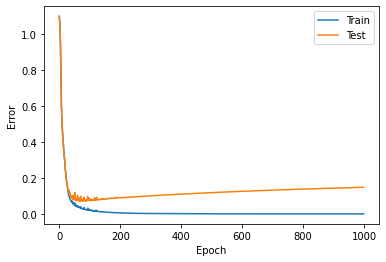

Accuracy Train:  100.0% Accuracy Test:  93.33333333333333%


In [15]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets

iris_data = datasets.load_iris()
input_data = iris_data.data
correct = iris_data.target
n_data = len(correct)

ave_input = np.average(input_data, axis=0)
std_input = np.std(input_data, axis=0)
input_data = (input_data - ave_input) / std_input

correct_data = np.zeros((n_data, 3)) # 150 X 3 짜리 행렬
for i in range(n_data):
  correct_data[i, correct[i]] = 1.0

index = np.arange(n_data)
index_train = index[index%2 == 0]
index_test = index[index%2 != 0]

input_train = input_data[index_train, :]
correct_train = correct_data[index_train, :]
input_test = input_data[index_test, :]
correct_test = correct_data[index_test, :]

n_train = len(input_train)
n_test = len(input_test)

n_in = 4
n_mid = 25
n_out = 3

wb_width = 0.1
eta = 0.01
epoch = 1000
batch_size = 8
interval = 100

class BaseLayer:
  def __init__(self, n_upper, n):
    self.w = wb_width * np.random.randn(n_upper, n)
    self.b = wb_width * np.random.randn(n)

  def update(self, eta):
    self.w -= eta * self.grad_w
    self.b -= eta * self.grad_b

class MiddleLayer(BaseLayer):
  def forward(self, x):
    self.x = x
    self.u = np.dot(x, self.w) + self.b
    self.y = np.where(self.u <= 0, 0, self.u)
  
  def backward(self, grad_y):
    delta = grad_y * np.where(self.u <= 0, 0, 1)

    self.grad_w = np.dot(self.x.T, delta)
    self.grad_b = np.sum(delta, axis=0)

    self.grad_x = np.dot(delta, self.w.T)

class OutputLayer(BaseLayer):
  def forward(self, x):
    self.x = x
    u = np.dot(x, self.w) + self.b
    self.y = np.exp(u)/np.sum(np.exp(u), axis=1, keepdims=True)
  
  def backward(self, t):
    delta = self.y - t

    self.grad_w = np.dot(self.x.T, delta)
    self.grad_b = np.sum(delta, axis=0)

    self.grad_x = np.dot(delta, self.w.T)
  
middle_layer_1 = MiddleLayer(n_in, n_mid)
middle_layer_2 = MiddleLayer(n_mid, n_mid)
output_layer = OutputLayer(n_mid, n_out)

def forward_propagation(x):
  middle_layer_1.forward(x)
  middle_layer_2.forward(middle_layer_1.y)
  output_layer.forward(middle_layer_2.y)

def back_propagation(t):
  output_layer.backward(t)
  middle_layer_2.backward(output_layer.grad_x)
  middle_layer_1.backward(middle_layer_2.grad_x)

def update_wb():
  middle_layer_1.update(eta)
  middle_layer_2.update(eta)
  output_layer.update(eta)

def get_error(t, batch_size):
  return -np.sum(t * np.log(output_layer.y + 1e-7)) / batch_size

train_error_x = []
train_error_y = []
test_error_x = []
test_error_y = []

#미니 배치법 구현
n_batch = n_train // batch_size
for i in range(epoch):

  forward_propagation(input_train)
  error_train = get_error(correct_train, n_train)
  forward_propagation(input_test)
  error_test = get_error(correct_test, n_test)

  test_error_x.append(i)
  test_error_y.append(error_test)
  train_error_x.append(i)
  train_error_y.append(error_train)

  if i%interval == 0:
    print("Epoch: " + str(i) + "/" + str(epoch),
          "Error_train : " + str(error_train),
          "Error_test: " + str(error_test))

  index_random = np.arange(n_train)
  np.random.shuffle(index_random)

  for j in range(n_batch):
    mb_index = index_random[j*batch_size : (j+1)*batch_size]
    x = input_train[mb_index, :]
    t = correct_train[mb_index, :]

    forward_propagation(x)
    back_propagation(t)

    update_wb()

plt.plot(train_error_x, train_error_y, label="Train")
plt.plot(test_error_x, test_error_y, label="Test")
plt.legend()

plt.xlabel("Epoch")
plt.ylabel("Error")

plt.show()

forward_propagation(input_train)
count_train = np.sum(np.argmax(output_layer.y, axis=1) == np.argmax(correct_train, axis=1))

forward_propagation(input_test)
count_test = np.sum(np.argmax(output_layer.y, axis=1) == np.argmax(correct_test, axis=1))

print("Accuracy Train: ", str(count_train/n_train*100) + "%",
      "Accuracy Test: ", str(count_test/n_test*100) + "%")
